In [2]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots

C:\Users\user\AppData\Local\Temp\ipykernel_4232\2412342140.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/Research/MSIS_RandD/IndustrialTimeSeries/ForStudents'
    DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/Research/MSIS_RandD/IndustrialTimeSeries/Data/'
else:
    DATA_DIR = 'Data/'

In [4]:
## Read data
FILE = 'timeseriesdata.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)
df['time'] = pd.to_datetime(df['time'], format='%m-%d-%Y %H.%M')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
df = df.set_index('time')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_4232\502638629.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


Text(0, 0.5, '% Missing Values')

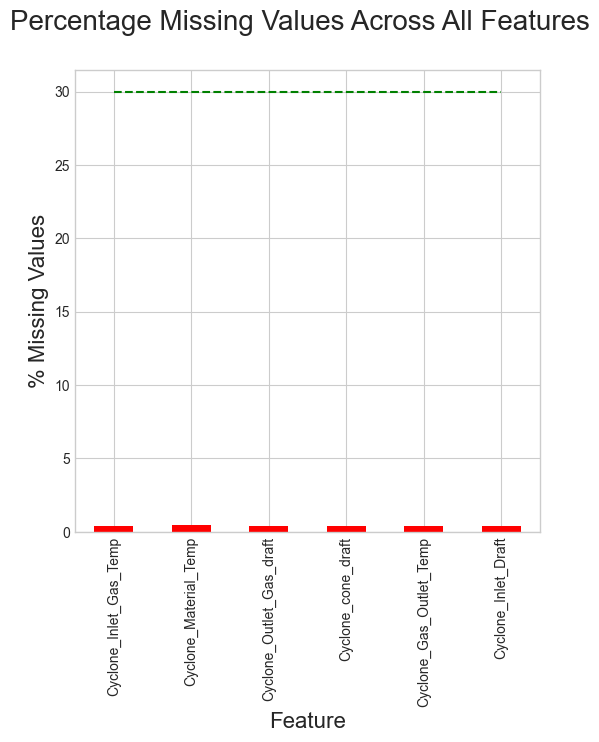

In [5]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [6]:
## Linear interpolation for one column
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

In [7]:
## Data preparation for anomaly detection using numpy (only one feature is considered)
feature = 'Cyclone_Inlet_Gas_Temp'
# Note that 5min is the sampling period in the dataset which we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
df_samples = pd.DataFrame(np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape))
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

,0,1,2,3,4,5
2017-01-01 00:00:00,0.429433,0.464612,0.453816,0.452633,0.502307,0.462519
2017-01-01 00:30:00,0.545613,0.460366,0.439684,0.544157,0.452117,0.531238
2017-01-01 01:00:00,0.450298,0.474316,0.436924,0.522959,0.408417,0.499820
2017-01-01 01:30:00,0.412936,0.440836,0.502550,0.430555,0.428827,0.433861
2017-01-01 02:00:00,0.468827,0.495363,0.438895,0.441139,0.447265,0.455574


In [8]:
## Data preparation for anomaly detection using numpy (all features are considered)
# Note that 5min is the sampling period in the dataset which we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
X = np.concatenate([np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape) for feature in df_transformed.columns.values], axis = 1)
df_samples = pd.DataFrame(X)
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2017-01-01 00:00:00,0.429433,0.464612,0.453816,0.452633,0.502307,0.462519,0.457338,0.479265,0.496420,0.493495,...,0.464489,0.463846,0.495128,0.477510,-0.062775,-0.112398,-0.051333,-0.023179,-0.030507,-0.075887
2017-01-01 00:30:00,0.545613,0.460366,0.439684,0.544157,0.452117,0.531238,0.573506,0.540303,0.537747,0.538684,...,0.480697,0.480697,0.502940,0.508762,-0.139009,-0.111626,-0.059175,-0.101085,-0.040920,-0.010580
2017-01-01 01:00:00,0.450298,0.474316,0.436924,0.522959,0.408417,0.499820,0.506731,0.536156,0.499687,0.553567,...,0.459005,0.510539,0.448281,0.490103,-0.109955,-0.031149,-0.072802,0.006004,0.021688,-0.117540
2017-01-01 01:30:00,0.412936,0.440836,0.502550,0.430555,0.428827,0.433861,0.491450,0.482077,0.520790,0.491052,...,0.496966,0.471505,0.464489,0.460598,-0.037449,-0.065603,-0.039763,-0.038092,-0.023436,0.008832
2017-01-01 02:00:00,0.468827,0.495363,0.438895,0.441139,0.447265,0.455574,0.518149,0.541553,0.536810,0.514258,...,0.498559,0.488908,0.495587,0.484128,0.062955,0.028758,-0.078330,-0.002481,-0.052490,-0.056475


In [9]:
X.shape

(62953, 36)

In [10]:
## Function to do dimension reduction by PCA of data matrix corresponding to each time stamp
def dimredux(x, pca, k):
  pca.fit(np.reshape(x, (int(X.shape[1] / len(df.columns)), len(df.columns))).T)
  # Return number of components required to explain at least 80% of the variance
  cumulative_variance = np.cumsum(pca.explained_variance_)
  print(k)
  print(cumulative_variance)
  k = k+1
  return(np.where(cumulative_variance / cumulative_variance[-1] >= 0.8)[0][0])

In [11]:
## Apply the dimension reduction function row by row to the timestamp matrix
## Note that the following is computationally slow
pca = PCA()
k = 0
#np.apply_along_axis(dimredux, 1, X, pca, k)

In [12]:
X.shape

(62953, 36)

In [13]:
X[0]

array([ 0.42943325,  0.4646117 ,  0.45381555,  0.45263283,  0.50230723,
        0.46251919,  0.45733781,  0.47926499,  0.49642045,  0.49349493,
        0.52505075,  0.51971098, -0.12163487, -0.06921178, -0.0383214 ,
       -0.01709055, -0.00873908, -0.10986231, -0.24128874, -0.19766119,
       -0.02459046, -0.1171606 , -0.10486959, -0.1520405 ,  0.42180981,
        0.45367378,  0.46448915,  0.46384574,  0.49512758,  0.47751048,
       -0.06277455, -0.11239771, -0.05133294, -0.02317886, -0.03050664,
       -0.0758874 ])

In [14]:
def pca_func(X,k):
    pca.fit(np.reshape(X[k, :], (int(X.shape[1] / len(df.columns)), len(df.columns))).T)
    cumulative_variance = np.cumsum(pca.explained_variance_)
    n_pca_components = ((np.where(cumulative_variance / cumulative_variance[-1] >= 0.8)[0][0]))
    return pca.components_[:, :n_pca_components+1]

In [15]:
subspaces = []
for i in range(3):
    subspaces.extend([pca_func(X,i)])

In [16]:
subspaces

[array([[-0.14273456, -0.18679845],
        [-0.46071122, -0.22749638],
        [ 0.3554922 ,  0.45989717],
        [ 0.04095738, -0.38627956],
        [-0.79779466,  0.39210582],
        [ 0.05332434,  0.63157538]]),
 array([[-0.1979902 , -0.03960368],
        [-0.92029554, -0.15421578],
        [-0.26774163,  0.18343681],
        [ 0.19040748, -0.4602864 ],
        [-0.05406867, -0.47633831],
        [ 0.05469909, -0.70868768]]),
 array([[-0.03725625,  0.06060878],
        [ 0.76312461,  0.41502158],
        [-0.0820869 , -0.08302113],
        [ 0.4796141 , -0.54785318],
        [-0.40367912,  0.34574001],
        [ 0.12856135,  0.63048544]])]

In [17]:
A = subspaces[0]
A

array([[-0.14273456, -0.18679845],
       [-0.46071122, -0.22749638],
       [ 0.3554922 ,  0.45989717],
       [ 0.04095738, -0.38627956],
       [-0.79779466,  0.39210582],
       [ 0.05332434,  0.63157538]])

In [18]:
B = subspaces[1]
B

array([[-0.1979902 , -0.03960368],
       [-0.92029554, -0.15421578],
       [-0.26774163,  0.18343681],
       [ 0.19040748, -0.4602864 ],
       [-0.05406867, -0.47633831],
       [ 0.05469909, -0.70868768]])

In [19]:
B.shape

(6, 2)

In [20]:
temp1 = np.matmul(A, A.T)
temp2 = np.matmul(B.T, temp1)
temp3 = np.matmul(temp2, B)
temp3

array([[0.17282677, 0.17042184],
       [0.17042184, 0.32521122]])

In [21]:
temp3
np.linalg.eig(temp3)

(array([0.06234051, 0.43569749]),
 array([[-0.83909081, -0.54399137],
        [ 0.54399137, -0.83909081]]))

In [22]:
np.sqrt(1 - min(np.linalg.eig(temp3)[0]))

0.9683281951672906

In [23]:
A = subspaces[1]
A

array([[-0.1979902 , -0.03960368],
       [-0.92029554, -0.15421578],
       [-0.26774163,  0.18343681],
       [ 0.19040748, -0.4602864 ],
       [-0.05406867, -0.47633831],
       [ 0.05469909, -0.70868768]])

In [24]:
B = subspaces[2]
B

array([[-0.03725625,  0.06060878],
       [ 0.76312461,  0.41502158],
       [-0.0820869 , -0.08302113],
       [ 0.4796141 , -0.54785318],
       [-0.40367912,  0.34574001],
       [ 0.12856135,  0.63048544]])

In [25]:
temp1 = np.matmul(A, A.T)
temp2 = np.matmul(B.T, temp1)
temp3 = np.matmul(temp2, B)
temp3

array([[0.3684749 , 0.36501972],
       [0.36501972, 0.40627152]])

In [26]:
np.sqrt(1 - min(np.linalg.eig(temp3)[0]))

0.9890072797183427

In [27]:
subspaces = []
for i in range(17514):
    subspaces.extend([pca_func(X,i)])
for i in range(17539, 42267):
    subspaces.extend([pca_func(X,i)])
for i in range(42275,62953):
    subspaces.extend([pca_func(X,i)])

In [28]:
len(subspaces)

62920

In [29]:
def angle_btw_subspaces(subspaces, vals):
    A = subspaces[vals+1]
    B = subspaces[vals+2]
    temp1 = np.matmul(B.T, A)
    temp2 = np.matmul(temp1, A.T)
    temp3 = np.matmul(temp2, B)
    delta_val = np.sqrt(1 - min(np.linalg.eig(temp3)[0]))
    return delta_val

In [30]:
delta_vals = []
for i in range(len(subspaces)-1):
    delta_vals.append(angle_btw_subspaces(subspaces, i-1))
delta_vals

[0.9683281951672906,
 0.9890072797183428,
 0.743892925762755,
 0.9972741991878316,
 0.99974415294087,
 0.8434927709094809,
 1.0,
 0.9568233148993427,
 0.9918391765839184,
 0.9665524834890482,
 0.46068267875025637,
 1.0,
 0.9572342626990772,
 0.9414867582964696,
 0.8666698954960217,
 0.9737153983898471,
 1.0,
 0.7833989587666365,
 0.9796655748377596,
 0.9998835615928134,
 0.877189804281462,
 0.9827254076939892,
 0.9273997459995345,
 0.7977964575818315,
 0.9986149037802527,
 0.9438128267627982,
 0.9939598099717146,
 0.9938660116603429,
 0.9580049293804508,
 0.9548594368592189,
 0.9979274828638125,
 1.0,
 0.984209374796545,
 0.9049296401145055,
 0.9178373530176833,
 0.8684232458914524,
 1.0,
 0.9977090904687788,
 0.661808909708367,
 1.0,
 0.2856472907397864,
 0.8260500084690816,
 0.8022424475491133,
 1.0,
 0.8821007759141187,
 0.9591531903986535,
 0.9899469657949439,
 0.9030963242798747,
 0.7345563856167276,
 1.0,
 0.9146165136552227,
 0.5482625881526956,
 0.9255430365764329,
 1.0,
 0.886

In [31]:
df.columns

Index(['Cyclone_Inlet_Gas_Temp', 'Cyclone_Material_Temp',
       'Cyclone_Outlet_Gas_draft', 'Cyclone_cone_draft',
       'Cyclone_Gas_Outlet_Temp', 'Cyclone_Inlet_Draft'],
      dtype='object')

In [32]:
from matplotlib.legend import Shadow
# User-defined function for producing a component plot of a vector
def plotveccomp(x, name = ' ', axis = None, linewidth = 1, color = 'black', marker = ''):
  ax = axis
  component_index = range(0, 17513)
  ax.plot(component_index, x, linewidth = linewidth, color = color, marker = marker)
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue',label='Mean')
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red',label='Z-Score')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.plot(component_index, [np.mean(x) - 3*np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='green',label='3 Std Deviations')
  plt.legend(framealpha=1, frameon=True,bbox_to_anchor=(1.0, 1.0))
  ax.set_xlabel('Timestamps (5min)')
  ax.set_ylabel('Feature')
  ax1.set_title('Cyclone_Inlet_Gas_Temp')
  ax2.set_title('Cyclone_Material_Temp')
  ax3.set_title('Cyclone_Outlet_Gas_draft')
  ax4.set_title('Cyclone_cone_draft')
  ax5.set_title('Cyclone_Gas_Outlet_Temp')
  ax6.set_title('Cyclone_Inlet_Draft')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


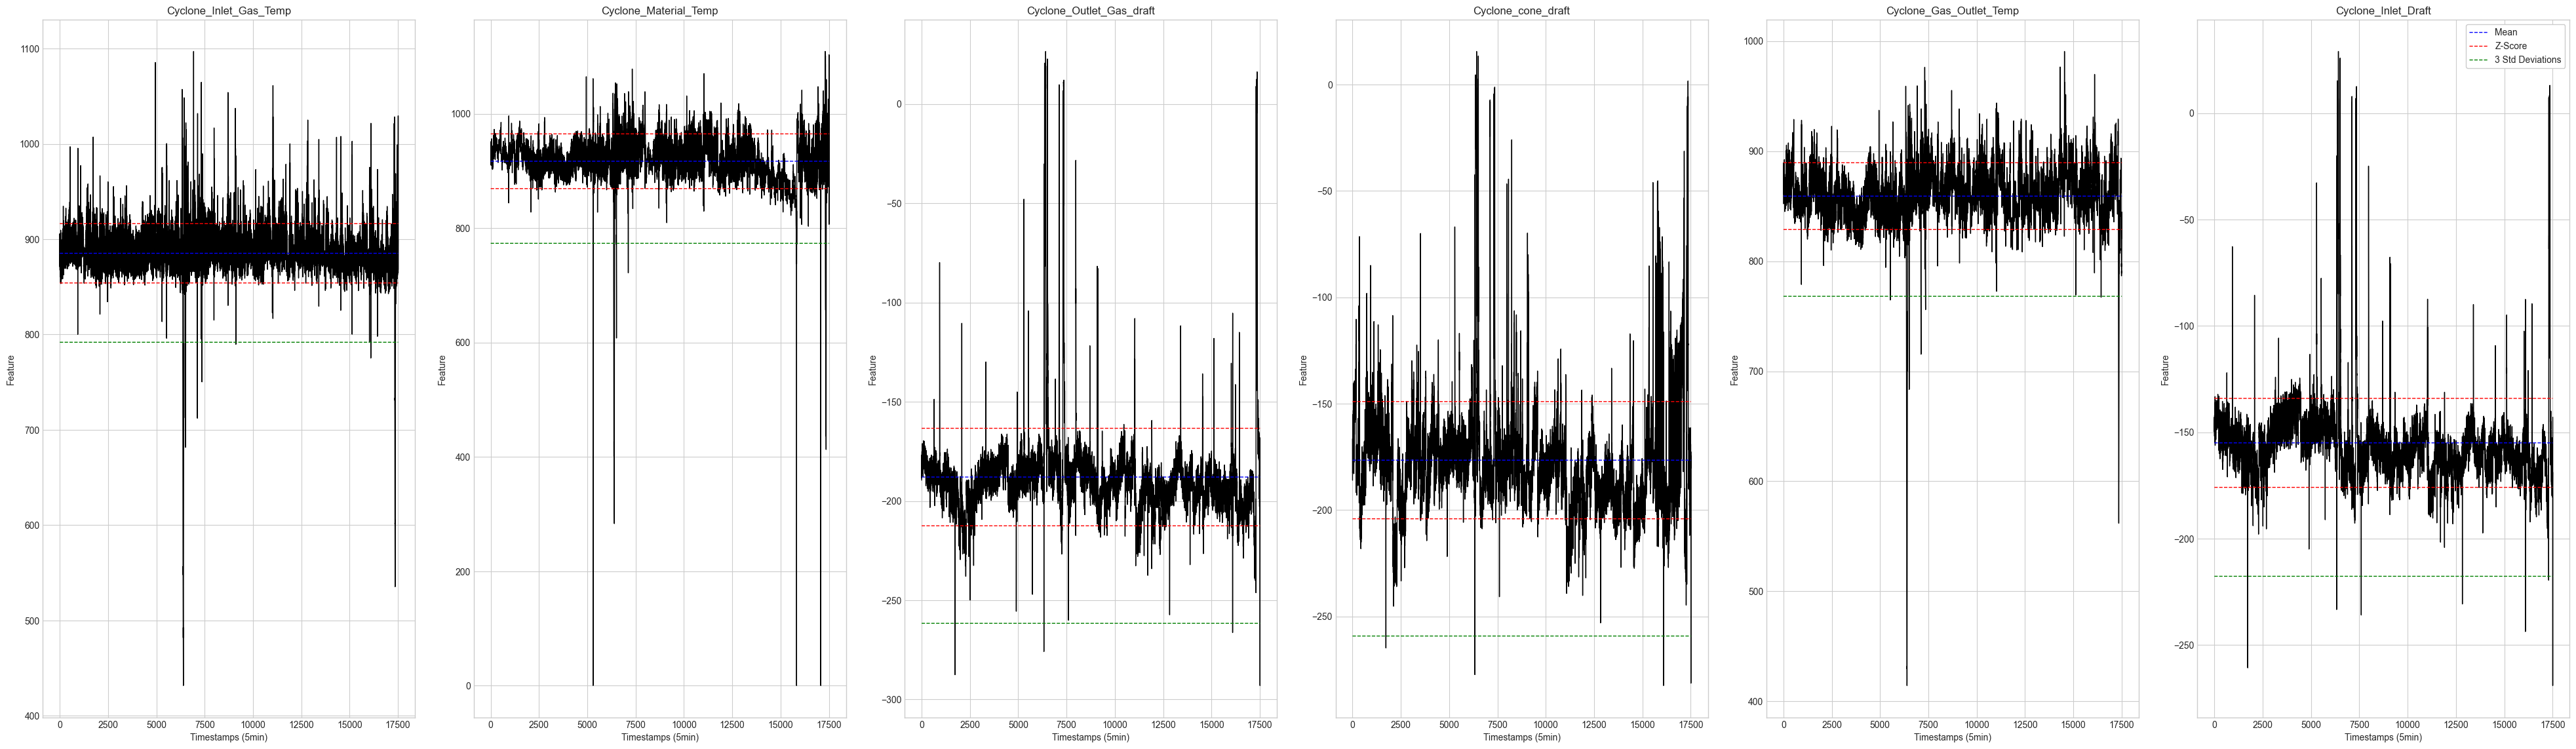

In [33]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (40,12))#24,5
fig.tight_layout(pad = 4.0)
plotveccomp(df.iloc[:17513,0], 'Cyclone_Inlet_Gas_Temp', ax1)
plotveccomp(df.iloc[:17513,1], 'Cyclone_Material_Temp', ax2)
plotveccomp(df.iloc[:17513,2], 'Cyclone_Outlet_Gas_draft', ax3)
plotveccomp(df.iloc[:17513,3], 'Cyclone_cone_draft', ax4)
plotveccomp(df.iloc[:17513,4], 'Cyclone_Gas_Outlet_Temp', ax5)
plotveccomp(df.iloc[:17513,5], 'Cyclone_Inlet_Draft', ax6)
plt.savefig('features.png')

In [34]:
from matplotlib.legend import Shadow
# User-defined function for producing a component plot of a vector
def plotveccomp(x, name = ' ', axis = None, linewidth = 1, color = 'black', marker = ''):
  ax = axis
  component_index = range(62919)
  ax.plot(component_index, x, linewidth = linewidth, color = color, marker = marker)
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue',label='Mean')
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red',label='Z-Score')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.plot(component_index, [np.mean(x) - 4*np.std(x)]*len(x), linewidth = 2, linestyle = 'dashed', color ='green',label='3 Std Deviations')
  plt.legend(framealpha=1, frameon=True,bbox_to_anchor=(1.0, 1.0))
  ax.set_xlabel('Time in minutes')
  ax.set_ylabel('Delta')
  ax1.set_title('Angle between Subspaces')

c:\Users\user\anaconda3\envs\pycaretenv\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


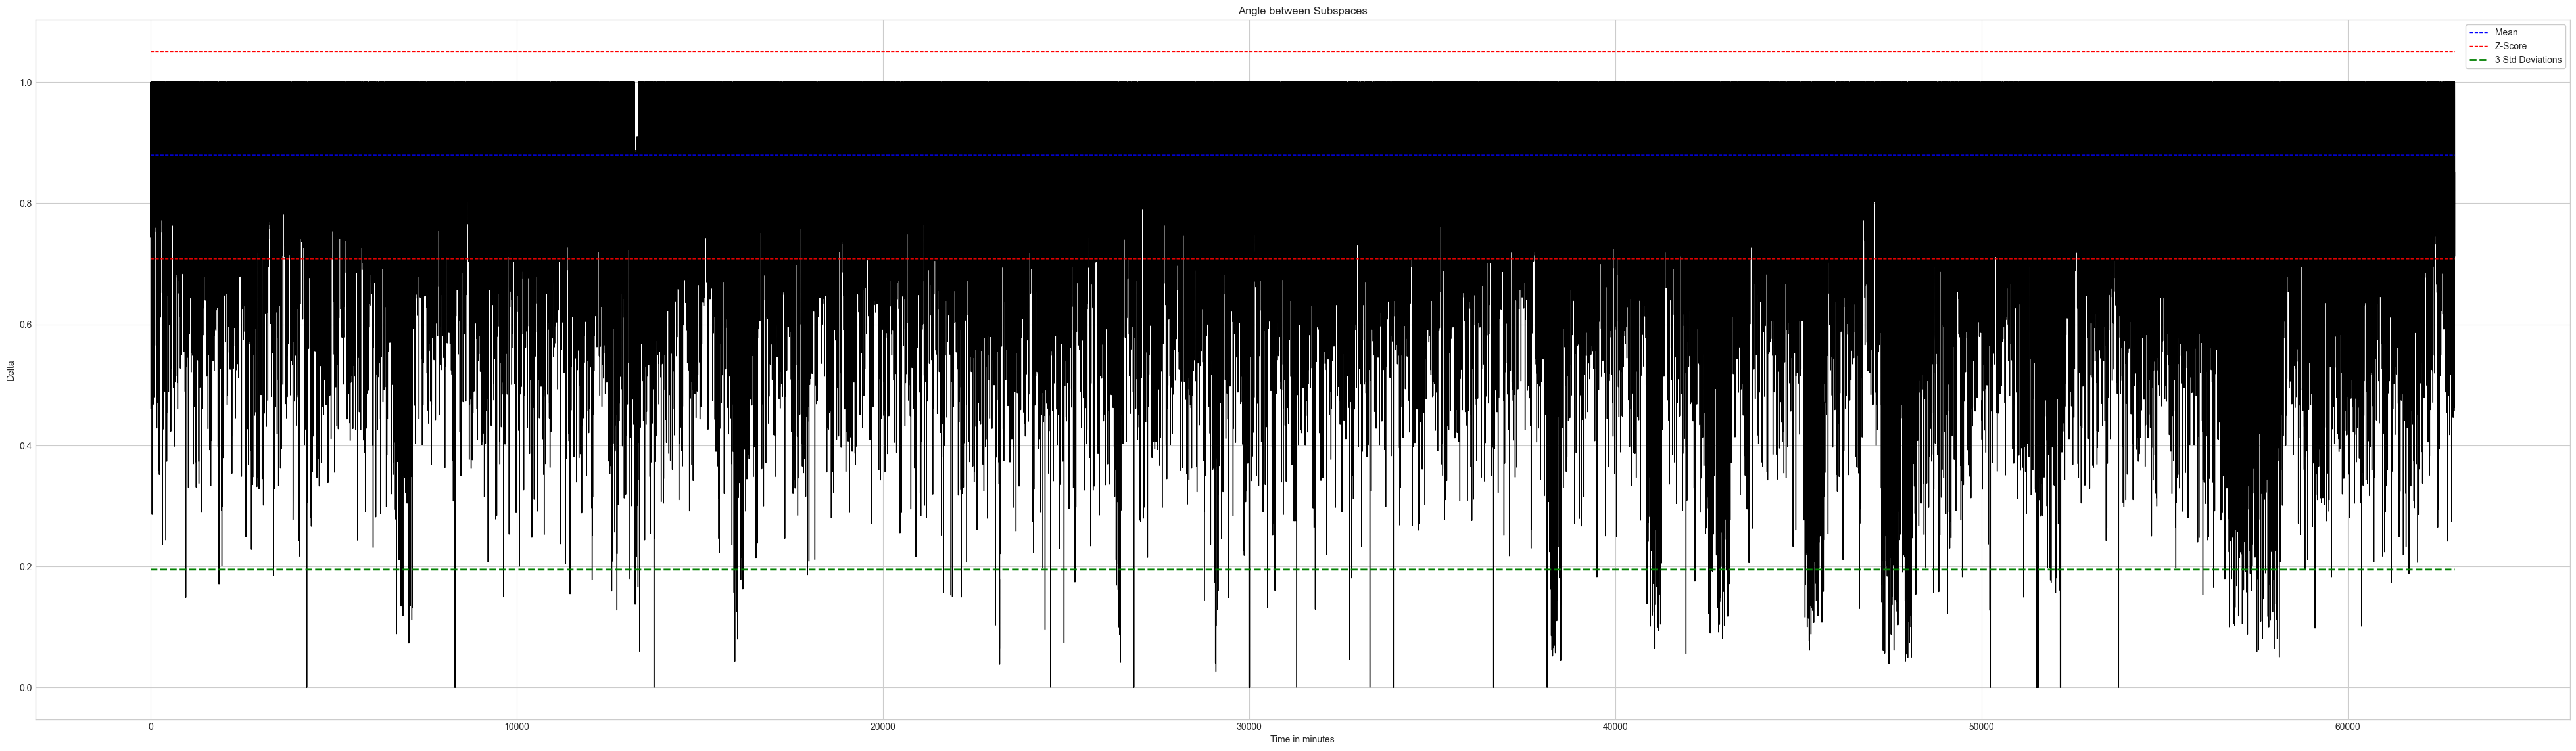

In [35]:
fig, (ax1) = plt.subplots(figsize = (40,12))#24,5
fig.tight_layout(pad = 4.0)
plotveccomp(delta_vals, 'Angle between subspaces', ax1)
plt.savefig('angle_btw_subspaces.png')

In [36]:
delta_vals = np.array(delta_vals)
stdd_four = 4*np.std(delta_vals)
stdd_four

0.6848166087558889

In [46]:
anomalies = X[np.where((delta_vals - stdd_four) <= 0.0)]
anomalies_index = np.where((delta_vals - stdd_four) <= 0.0)
print(anomalies_index)
len(anomalies_index[0])

(array([   10,    38,    40, ..., 62906, 62912, 62914], dtype=int64),)


8071

In [47]:
def plotveccomp(x, name = ' ', axis = None, linewidth = 1, color = 'black', marker = ''):
  ax = axis
  component_index = range(len(anomalies_index[0]))
  ax.plot(component_index, x, linewidth = linewidth, color = color, marker = marker)
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue',label='Mean')
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red',label='Z-Score')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  plt.legend(framealpha=1, frameon=True,bbox_to_anchor=(1.0, 1.0))
  ax.set_xlabel('Time in mins')
  ax.set_ylabel('Feature')
  ax1.set_title('Cyclone_Inlet_Gas_Temp')
  ax2.set_title('Cyclone_Material_Temp')
  ax3.set_title('Cyclone_Outlet_Gas_draft')
  ax4.set_title('Cyclone_cone_draft')
  ax5.set_title('Cyclone_Gas_Outlet_Temp')
  ax6.set_title('Cyclone_Inlet_Draft')

In [48]:
anomaly_entries = []
for i in range(len(anomalies_index[0])):
    anom = X[anomalies_index[0][i]]
    anomaly_entries.append(anom)
anomaly_entries = np.array(anomaly_entries)
anomaly_entries = anomaly_entries.reshape(8071, 6, 6)
anomaly_entries[:,0][:,0]

array([0.39285979, 0.4730424 , 0.47792492, ..., 0.48972183, 0.55643958,
       0.5288427 ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


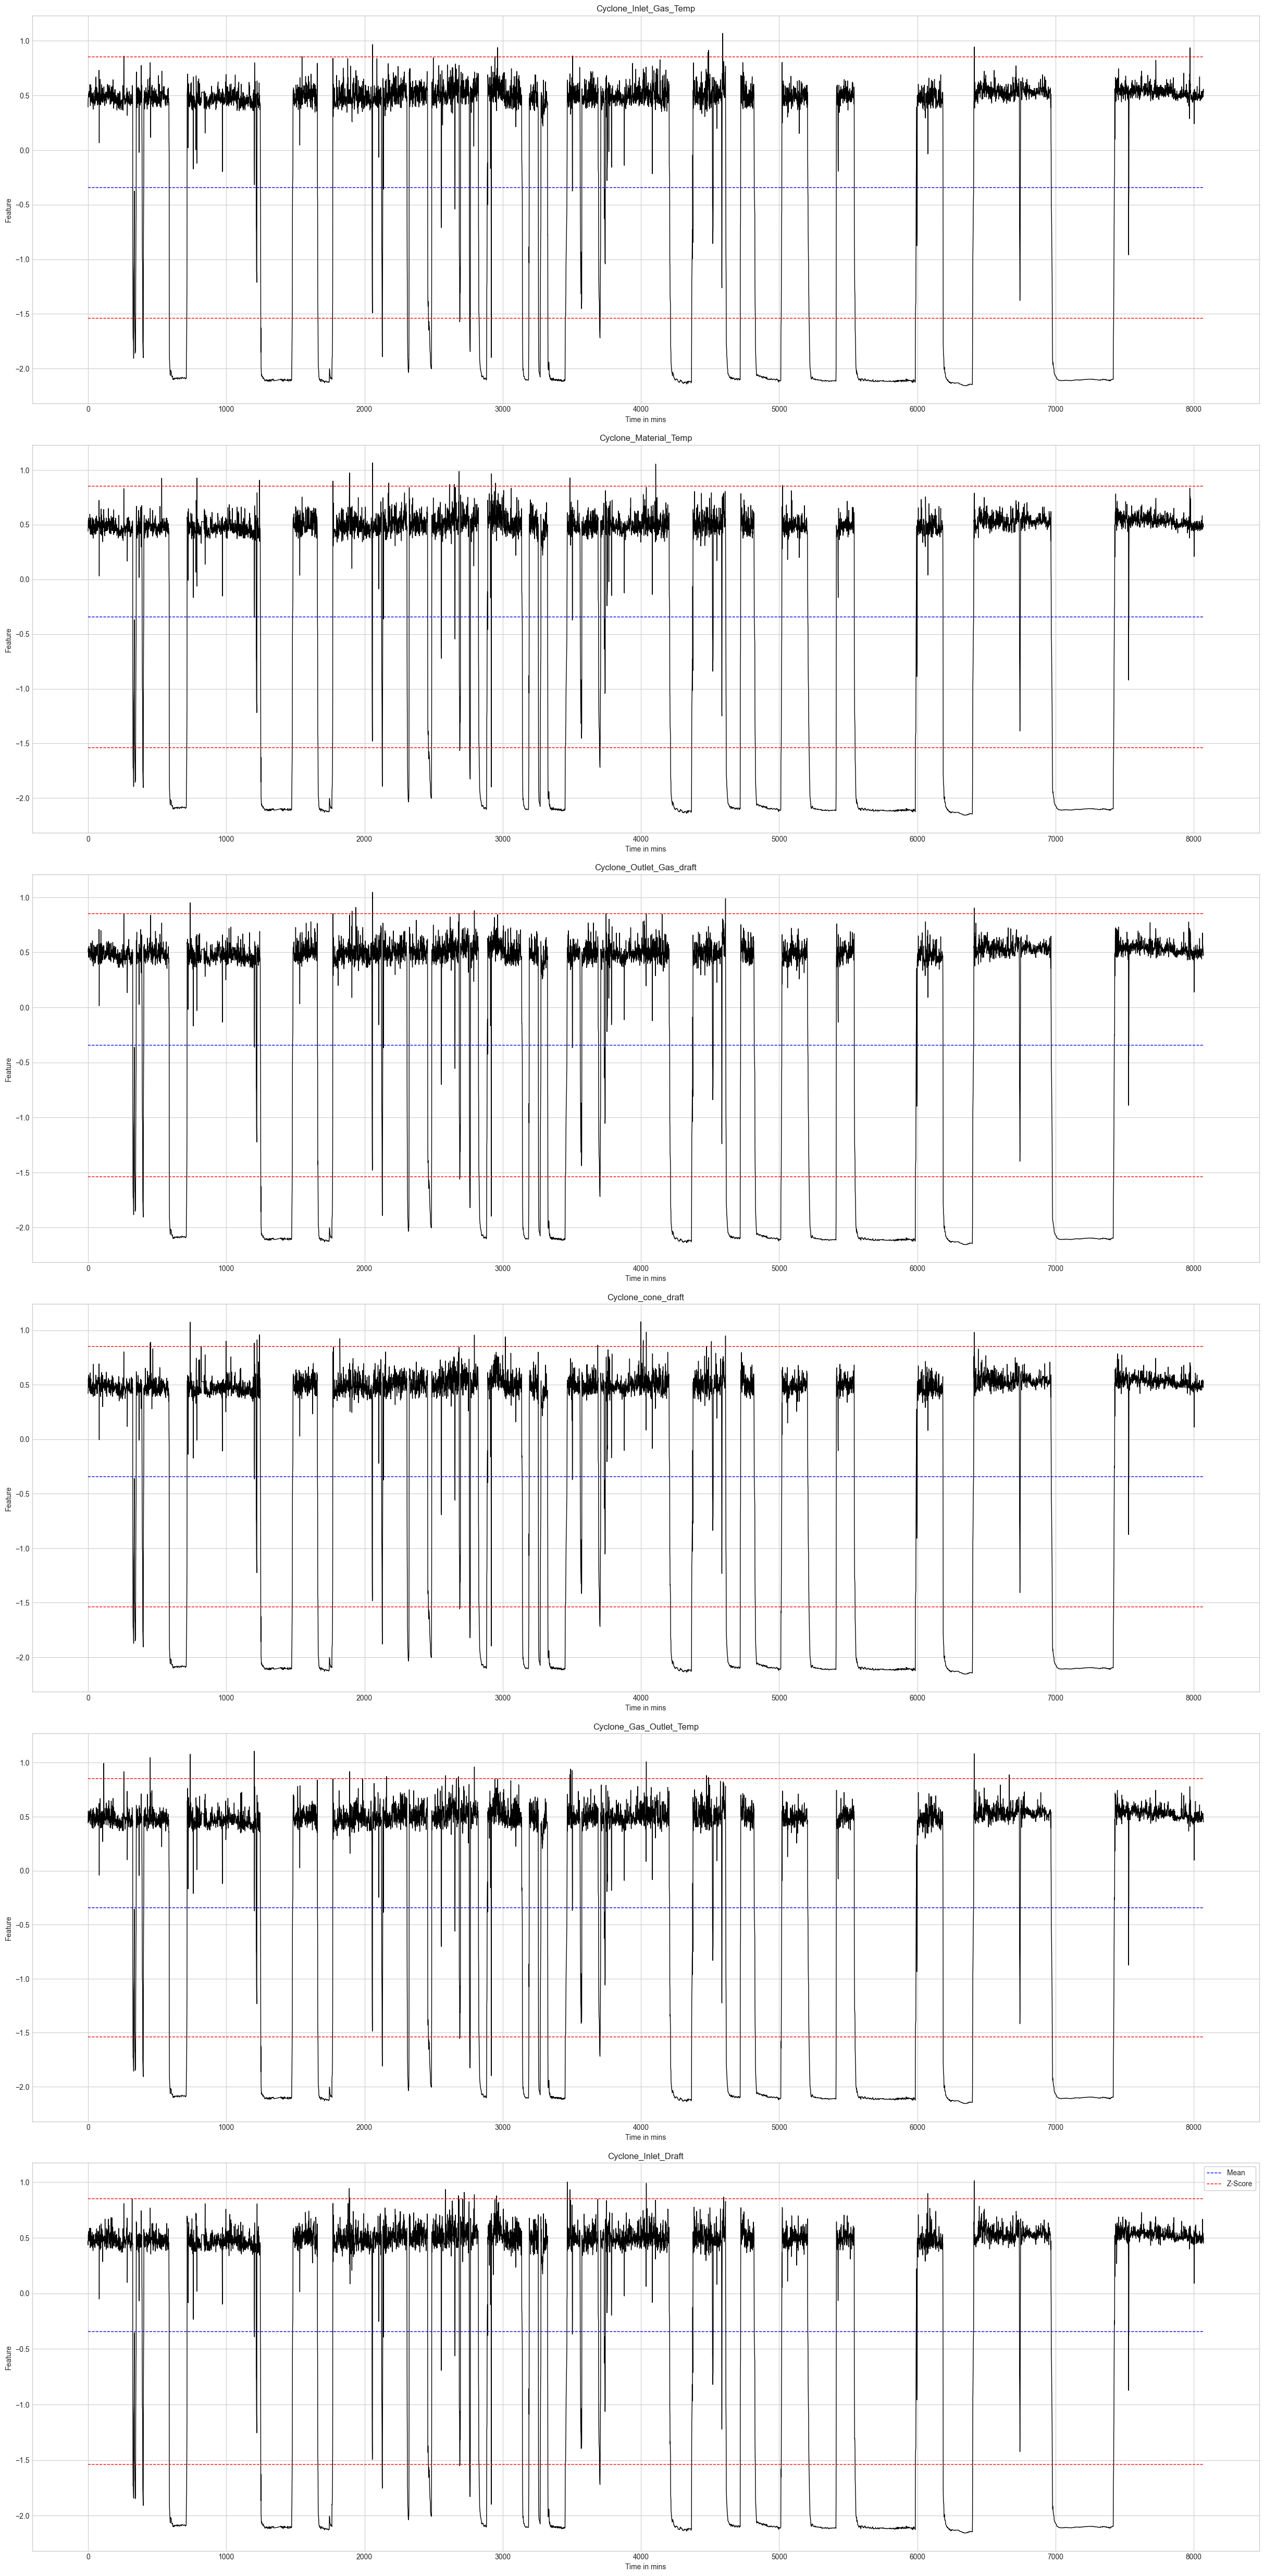

In [53]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize = (25,50))#24,5
fig.tight_layout(pad = 4.0)
plotveccomp(anomaly_entries[:,0][:,0], 'Cyclone_Inlet_Gas_Temp', ax1)
plotveccomp(anomaly_entries[:,0][:,1], 'Cyclone_Material_Temp', ax2)
plotveccomp(anomaly_entries[:,0][:,2], 'Cyclone_Outlet_Gas_draft', ax3)
plotveccomp(anomaly_entries[:,0][:,3], 'Cyclone_cone_draft', ax4)
plotveccomp(anomaly_entries[:,0][:,4], 'Cyclone_Gas_Outlet_Temp', ax5)
plotveccomp(anomaly_entries[:,0][:,5], 'Cyclone_Inlet_Draft', ax6)
plt.savefig('anomaly_plots.png')

In [59]:
not_anomalies = X[np.where((delta_vals - stdd_four) > 0.0)]
not_anomalies_index = np.where((delta_vals - stdd_four) > 0.0)
print(not_anomalies_index)
len(not_anomalies_index[0])

(array([    0,     1,     2, ..., 62916, 62917, 62918], dtype=int64),)


54848

In [60]:
def plotveccomp(x, name = ' ', axis = None, linewidth = 1, color = 'black', marker = ''):
  ax = axis
  component_index = range(len(not_anomalies_index[0]))
  ax.plot(component_index, x, linewidth = linewidth, color = color, marker = marker)
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue',label='Mean')
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red',label='Z-Score')
  ax.plot(component_index, [np.mean(x) - 2*np.std(x)]*len(x), linewidth = 2, linestyle = 'dashed', color ='green',label='2 SDs')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  plt.legend(framealpha=1, frameon=True,bbox_to_anchor=(1.0, 1.0))
  ax.set_xlabel('Time in mins')
  ax.set_ylabel('Feature')
  ax1.set_title('Cyclone_Inlet_Gas_Temp')
  ax2.set_title('Cyclone_Material_Temp')
  ax3.set_title('Cyclone_Outlet_Gas_draft')
  ax4.set_title('Cyclone_cone_draft')
  ax5.set_title('Cyclone_Gas_Outlet_Temp')
  ax6.set_title('Cyclone_Inlet_Draft')

In [61]:
not_anomaly_entries = []
for i in range(len(not_anomalies_index[0])):
    anom = X[not_anomalies_index[0][i]]
    not_anomaly_entries.append(anom)
not_anomaly_entries = np.array(not_anomaly_entries)
not_anomaly_entries = not_anomaly_entries.reshape(54848, 6, 6)
not_anomaly_entries[:,0][:,0]

array([0.42943325, 0.54561311, 0.45029771, ..., 0.46370191, 0.46634029,
       0.49190532])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


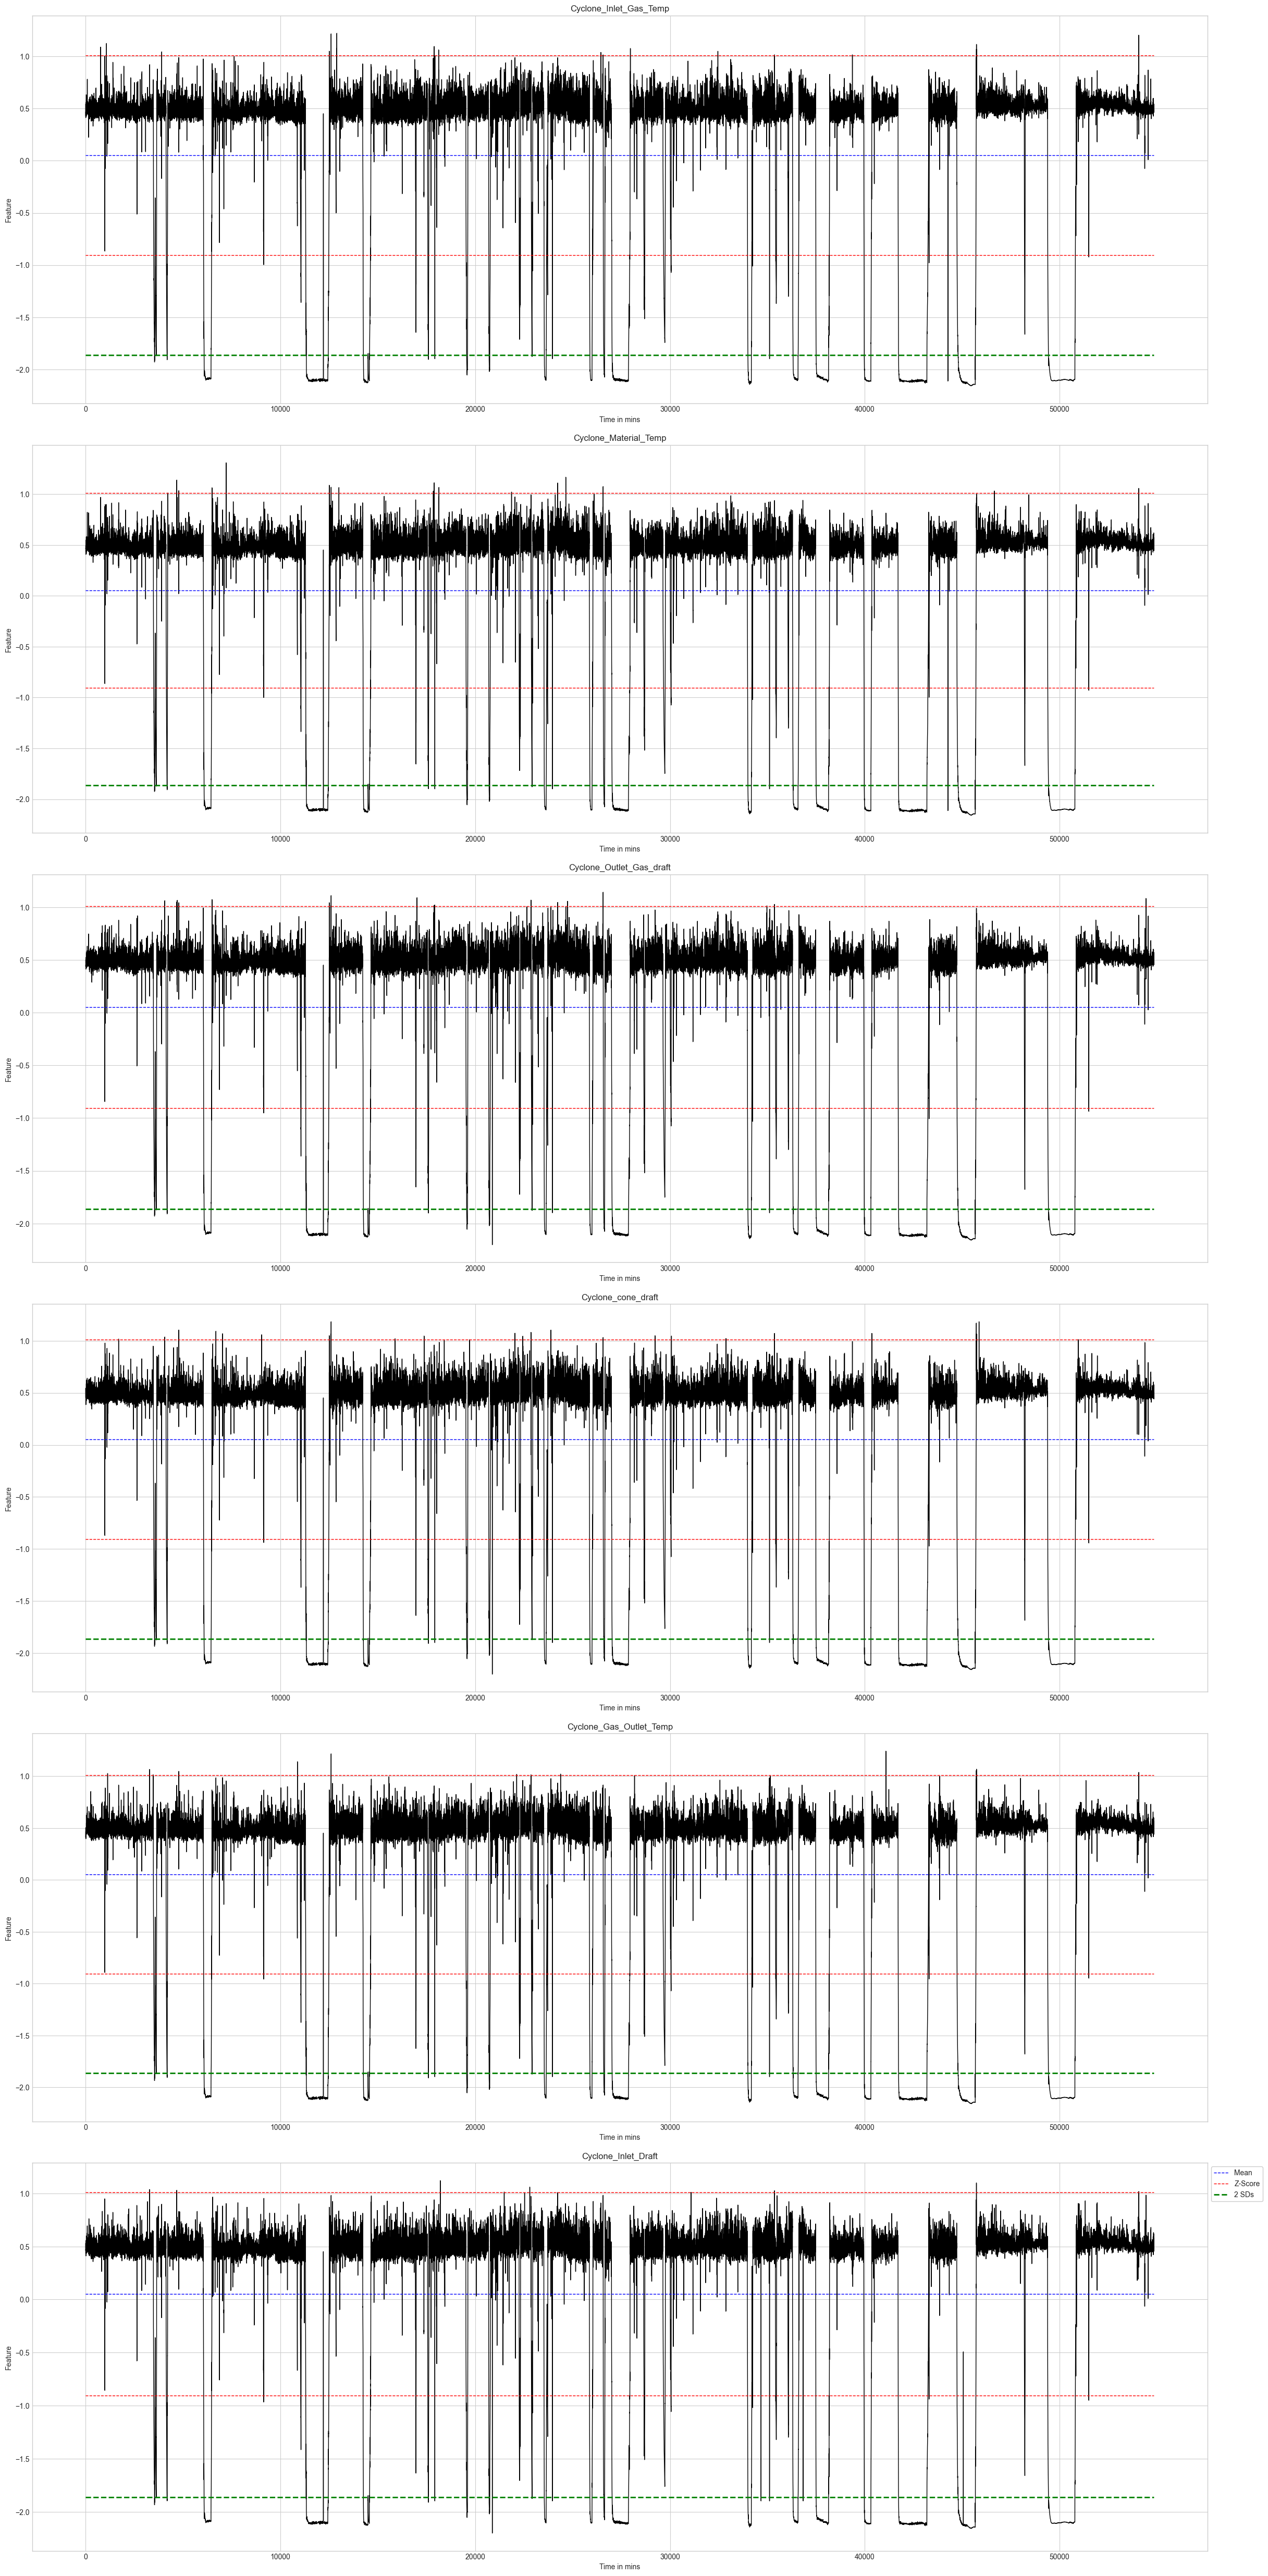

In [62]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize = (24,50))#24,5
fig.tight_layout(pad = 4.0)
plotveccomp(not_anomaly_entries[:,0][:,0], 'Cyclone_Inlet_Gas_Temp', ax1)
plotveccomp(not_anomaly_entries[:,0][:,1], 'Cyclone_Material_Temp', ax2)
plotveccomp(not_anomaly_entries[:,0][:,2], 'Cyclone_Outlet_Gas_draft', ax3)
plotveccomp(not_anomaly_entries[:,0][:,3], 'Cyclone_cone_draft', ax4)
plotveccomp(not_anomaly_entries[:,0][:,4], 'Cyclone_Gas_Outlet_Temp', ax5)
plotveccomp(not_anomaly_entries[:,0][:,5], 'Cyclone_Inlet_Draft', ax6)
plt.savefig('non_anomaly_plots.png')

In [ ]:
pd.concat([df.iloc[:17514, :],df.iloc[17539:42267,:],df.iloc[42275:, :]])

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39
...,...,...,...,...,...,...
2020-08-07 11:55:00,899.42,919.79,-224.07,-209.77,901.01,-175.15
2020-08-07 12:00:00,879.90,895.02,-228.04,-211.28,878.08,-176.94
2020-08-07 12:05:00,887.20,895.70,-230.11,-214.65,885.32,-179.18
